Primeros 500 caracteres del archivo: Compañeras compañero querida patrio hoy frente tú dirijo presidente comprometido principio justicia social dignidad nacional bien colectivo Represento movimiento nacer corazón pueblo movimiento rechazar cadena neoliberalismo levantar fuerza construir patria verdaderamente libre justo soberano década modelo neoliberal instaurar país dogma incuestionable promesa modernidad prosperidad traducir desigualdad pobreza dependencia ver cómo institución entregar mejor postor cómo recurso natural saquear b
Cantidad de fragmentos obtenidos: 16
Primeros 10 fragmentos: ['Compañeras compañero querida patrio hoy frente tú dirijo presidente comprometido principio justicia social dignidad nacional bien colectivo Represento movimiento nacer corazón pueblo movimiento rechazar cadena neoliberalismo levantar fuerza construir patria', 'verdaderamente libre justo soberano década modelo neoliberal instaurar país dogma incuestionable promesa modernidad prosperidad traducir d

Device set to use cpu


Modelo cargado correctamente.


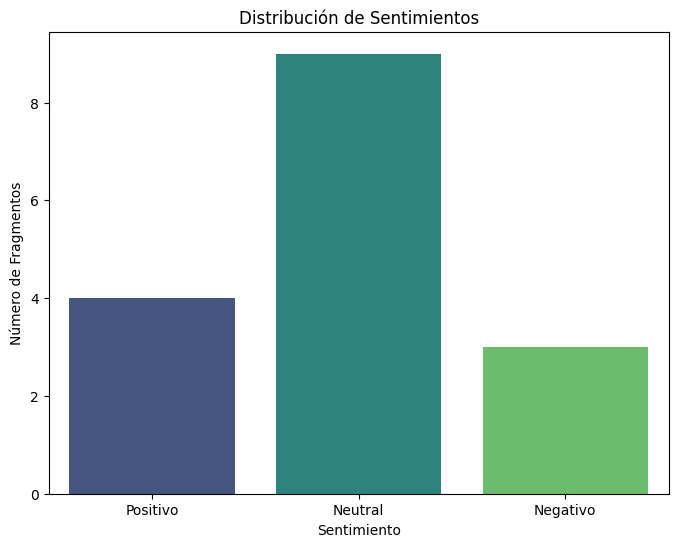

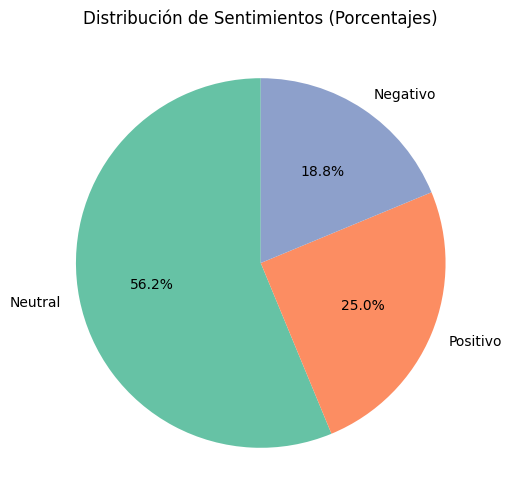

C:\Users\adega\AppData\Local\Temp\ipykernel_13184\2274715166.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=puntuacion_promedio, x='Sentimiento', y='Puntuación', palette='viridis')


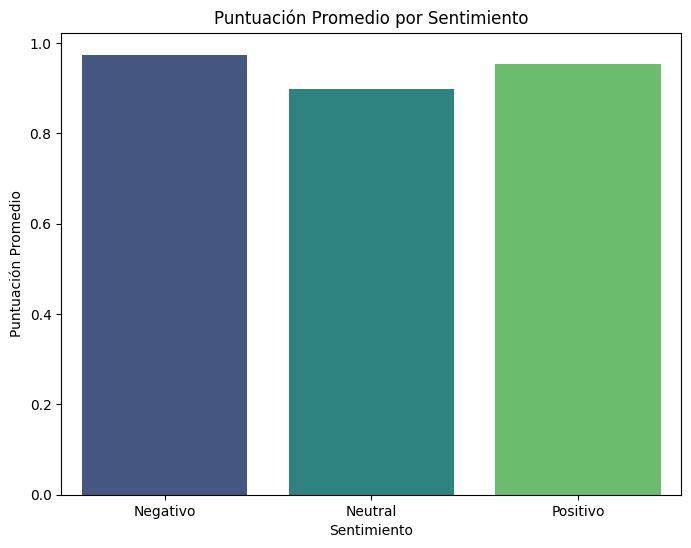

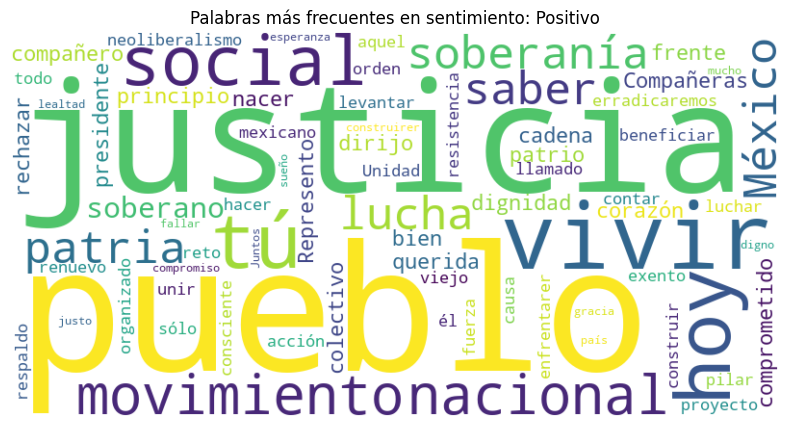

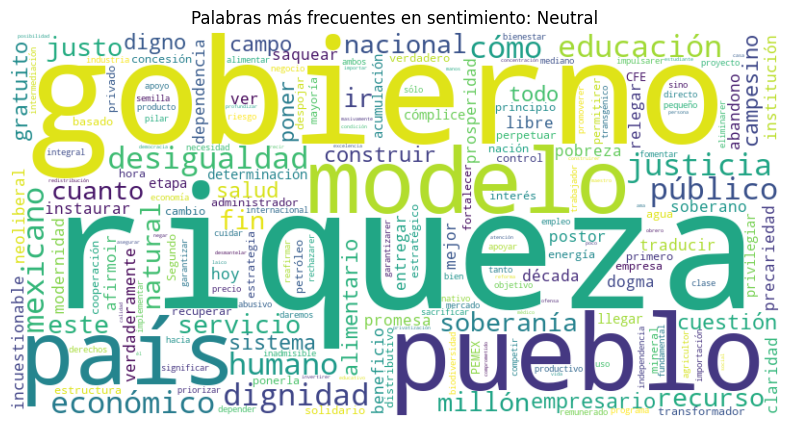

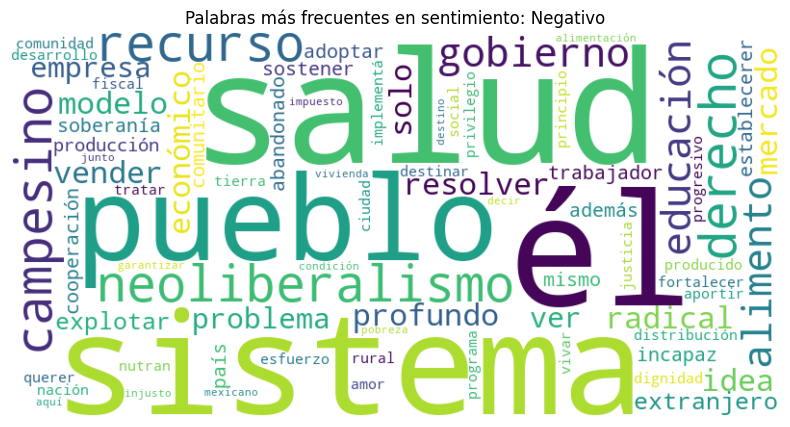

Análisis completado y guardado.


In [2]:
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy

# Cargar el modelo de spaCy para español
nlp = spacy.load("es_core_news_sm")

# Paso 1: Leer el texto preprocesado
try:
    with open('Claudia_Sheinbaum_Pardo_Procesado.txt', 'r', encoding='utf-8') as file:
        texto = file.read().strip()
    print("Primeros 500 caracteres del archivo:", texto[:500])  # Verificación del contenido
except FileNotFoundError:
    print("Error: No se encontró el archivo 'Claudia_Sheinbaum_Pardo_Procesado.txt'.")
    exit()

if not texto:
    print("Error: El archivo está vacío.")
    exit()

# Paso 2: Segmentación de texto mejorada
def segmentar_texto(texto, palabras_por_fragmento=30):
    """
    Divide el texto en fragmentos basados en un número específico de palabras por fragmento.
    :param texto: Texto completo a segmentar.
    :param palabras_por_fragmento: Número de palabras por fragmento (por defecto: 30).
    :return: Lista de fragmentos.
    """
    # Procesar con spaCy
    doc = nlp(texto)

    # Obtener todas las oraciones
    oraciones = [sent.text.strip() for sent in doc.sents]

    fragmentos = []
    temp_fragment = ""
    palabras_acumuladas = 0

    for oracion in oraciones:
        palabras_oracion = oracion.split()
        
        # Si la oración es demasiado larga, dividirla en fragmentos más pequeños
        if len(palabras_oracion) > palabras_por_fragmento:
            for i in range(0, len(palabras_oracion), palabras_por_fragmento):
                fragmento = " ".join(palabras_oracion[i:i + palabras_por_fragmento])
                fragmentos.append(fragmento)
        else:
            # Si el fragmento actual supera el tamaño deseado, lo agregamos a la lista
            if palabras_acumuladas + len(palabras_oracion) > palabras_por_fragmento and temp_fragment:
                fragmentos.append(temp_fragment.strip())
                temp_fragment = oracion
                palabras_acumuladas = len(palabras_oracion)
            else:
                temp_fragment += " " + oracion
                palabras_acumuladas += len(palabras_oracion)
    
    # Agregar el último fragmento si no está vacío
    if temp_fragment.strip():
        fragmentos.append(temp_fragment.strip())

    return fragmentos

fragmentos = segmentar_texto(texto, palabras_por_fragmento=30)
print(f"Cantidad de fragmentos obtenidos: {len(fragmentos)}")
print("Primeros 10 fragmentos:", fragmentos[:10])

# Paso 3: Cargar el modelo de análisis de sentimientos
modelo_espanol = "finiteautomata/beto-sentiment-analysis"
try:
    sentiment_pipeline = pipeline("sentiment-analysis", model=modelo_espanol)
    print("Modelo cargado correctamente.")
except Exception as e:
    print(f"Error al cargar el modelo de análisis de sentimientos: {e}")
    exit()

# Función para convertir etiquetas a sentimientos
def convertir_sentimiento(label, score):
    if label == "NEG" and score > 0.6:
        return "Negativo"
    elif label == "NEU" or (label in ["NEG", "POS"] and score < 0.6):
        return "Neutral"
    else:
        return "Positivo"

# Analizar sentimientos de cada fragmento
resultados = []
for fragmento in fragmentos:
    try:
        resultado = sentiment_pipeline(fragmento[:512])[0]  # Limitar a 512 tokens
        sentimiento = convertir_sentimiento(resultado['label'], resultado['score'])
        resultados.append({
            'Fragmento': fragmento,
            'Sentimiento': sentimiento,
            'Puntuación': resultado['score']
        })
    except Exception as e:
        print(f"Error al procesar el fragmento: {fragmento[:100]}")
        print(f"Error: {e}")
        resultados.append({'Fragmento': fragmento, 'Sentimiento': "Neutral", 'Puntuación': 1.0})

# Crear un DataFrame con los resultados
df_resultados = pd.DataFrame(resultados)

if df_resultados.empty:
    print("El DataFrame está vacío. No hay datos para analizar.")
    exit()

# Visualización de resultados (gráfico de barras)
plt.figure(figsize=(8, 6))
sns.countplot(data=df_resultados, x='Sentimiento', palette='viridis', hue='Sentimiento', legend=False)
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Número de Fragmentos')
plt.show()

# Nueva gráfica de pastel con porcentajes
distribucion_sentimientos = df_resultados['Sentimiento'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(
    distribucion_sentimientos,  # Valores
    labels=distribucion_sentimientos.index,  # Etiquetas (Positivo, Neutral, Negativo)
    autopct='%1.1f%%',  # Mostrar porcentajes con un decimal
    colors=['#66c2a5', '#fc8d62', '#8da0cb'],  # Colores personalizados
    startangle=90  # Rotación inicial
)
plt.title('Distribución de Sentimientos (Porcentajes)')
plt.show()

# Puntuación promedio por sentimiento
df_resultados['Puntuación'] = pd.to_numeric(df_resultados['Puntuación'])
puntuacion_promedio = df_resultados.groupby('Sentimiento')['Puntuación'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=puntuacion_promedio, x='Sentimiento', y='Puntuación', palette='viridis')
plt.title('Puntuación Promedio por Sentimiento')
plt.xlabel('Sentimiento')
plt.ylabel('Puntuación Promedio')
plt.show()

# Nubes de palabras por sentimiento
for sentimiento in df_resultados['Sentimiento'].unique():
    texto_sentimiento = ' '.join(df_resultados[df_resultados['Sentimiento'] == sentimiento]['Fragmento'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto_sentimiento)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Palabras más frecuentes en sentimiento: {sentimiento}')
    plt.show()

# Guardar los resultados
df_resultados.to_csv('Resultados_Analisis_Sentimientos_Sheinbaum.csv', index=False, encoding='utf-8')

try:
    df_resultados.to_excel('Resultados_Analisis_Sentimientos_Sheinbaum.xlsx', index=False)
    print("Análisis completado y guardado.")
except PermissionError:
    print("Error: No se pudo guardar el archivo Excel. Cierra el archivo si está abierto e intenta nuevamente.")